# Camera calibration

- In this section, I wanna calibrate the camera to get the camera matrix:<img src="cameraMatrix.png" width="200" height="200"> based on the opencv Camera Calibration template.

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import math

In [3]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 26, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('img/*.jpg')


for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imshow('gray',gray)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points (after refining them)
    print(ret)
    if ret == True:
        objpoints.append(objp)
        corners2=cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners2, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

True
True
True
True
True
True
True
True
True
True
True


In [5]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)
K= mtx

[[3.60700612e+03 0.00000000e+00 1.46342552e+03]
 [0.00000000e+00 3.56688419e+03 1.92973393e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [6]:
def cylindricalWarpImage(img1, K, savefig):
    fx = K[0,0]
    fy = K[1,1]
    (im_h,im_w) = img1.shape[:2]

    # go inverse from cylindrical coord to the image
    # (this way there are no gaps)
    cyl = np.zeros_like(img1)
    cyl_mask = np.zeros_like(img1)
    (cyl_h,cyl_w) = cyl.shape[:2]
    
    x_c = K[0,2]
    y_c = K[1,2]
#     x_c = float(cyl_w) / 2.0
#     y_c = float(cyl_h) / 2.0
    for x_cyl in np.arange(0,cyl_w):
        for y_cyl in np.arange(0,cyl_h):
            theta = (x_cyl - x_c) / fx
            h     = (y_cyl - y_c) / fy

            X = np.array([math.sin(theta), h, math.cos(theta)])
            X = np.dot(K,X)
            x_im = X[0] / X[2]
            if x_im < 0 or x_im >= im_w:
                continue

            #here use offset to overcome the translation of the phi, also can use zeropadding to the img,then spherical warping
            y_im = X[1] / X[2]         
            if y_im < 0 or y_im >= im_h:
                continue

            cyl[int(y_cyl),int(x_cyl)] = img1[int(y_im),int(x_im)]
            cyl_mask[int(y_cyl),int(x_cyl)] = 255


#     if savefig:
#         plt.imshow(cyl, cmap='gray')
#         plt.savefig("cyl.png",bbox_inches='tight')

    return (cyl,cyl_mask)


In [7]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # loop over the matches
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # only process the match if the keypoint was successfully
        # matched
        if s == 1:
            # draw the match
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (255, 0, 0), 1)
    # return the visualization
    return vis


In [102]:
def showImages(img1,sph1):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img1.astype(np.uint8), cv2.COLOR_BGR2RGB))
    # plt.title('spherical')
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(sph1.astype(np.uint8), cv2.COLOR_BGR2RGB))
    # plt.title('spherical')
    plt.show()

In [97]:
def sphericalStitching(sph1,img2,K_down,theta_i,phi_i,offset,edge):
    
    sph2 = resize_SphericalWarping(img2,K_down,theta_i,phi_i,offset,edge)

    flatOutput,affineMatrix = stitching(sph1,sph2)

    theta_i,phi_i = getThetaAndPhi(affineMatrix,theta_i,phi_i)
    
    print(phi_i/math.pi*180)
        
    offset = getOffset(K_down,phi_i)

    sph2_rotated = resize_SphericalWarping(img2,K_down,theta_i,phi_i,offset,edge)

    sphericalOutput1,affineMatrix = stitching(sph1,sph2_rotated)
    
    theta_i,phi_i = getThetaAndPhi(affineMatrix,theta_i,phi_i)
    
    print(phi_i/math.pi*180)
    #=======================================
#     sph2_rotated = resize_SphericalWarping(img2,K_down,theta_i,phi_i,offset+200)

#     sphericalOutput2,affineMatrix = stitching(sph1,sph2_rotated)
    
#     theta_i,phi_i = getThetaAndPhi(affineMatrix,theta_i,phi_i)
#     print(phi_i/math.pi*180)

    return sphericalOutput1, theta_i,phi_i


In [51]:
def sphericalWarpImage(img1, K,theta_i,phi_i,offset,edge):
    fx = K[0,0]
    fy = K[1,1]
    x_c = K[0,2]
    y_c = K[1,2]
    #padding the image 
#     offset = math.fabs(phi_i)/math.fabs(( 0 - y_c) / fy)*fy/2
#     offset = int(offset+offset/3)
#     print(offset)
#     img1 = cv2.copyMakeBorder(img1,offset,0,100,100,cv2.BORDER_CONSTANT)

    (im_h,im_w) = img1.shape[:2]

    # go inverse from cylindrical coord to the image
    # (this way there are no gaps)

    

#     print(cyl_h)
#     print(cyl_w)


    flag = False
#while up_stitching, up_padding, down_stitching, down_padding

    if edge !=0:
        up_edge = offset
        down_edge = offset
        x_edge = edge
        cyl = np.zeros((im_h+2*offset,im_w+2*edge,3))
        cyl_mask = np.zeros((im_h+2*offset,im_w+2*edge,3))
        (cyl_h,cyl_w) = (im_h,im_w)
    else:
        cyl = np.zeros((im_h+int(math.fabs(offset)),im_w+2*int(math.fabs(offset)),3))
        cyl_mask = np.zeros((im_h+int(math.fabs(offset)),im_w+2*int(math.fabs(offset)),3))
        (cyl_h,cyl_w) = (im_h,im_w)
        if offset>0:
            up_edge = offset
            down_edge = 0
            x_edge = offset
        else:
            offset = -offset
            up_edge = 0
            down_edge = offset
            x_edge = offset
    
    print(cyl.shape)   
    
    for y_cyl in np.arange(-up_edge,im_h+down_edge):    #row
        for x_cyl in np.arange(-x_edge,im_w+x_edge):   #column
            theta = (x_cyl - x_c) / fx
            phi     =( y_cyl - y_c) / fy
    
            X = np.array([math.sin(theta)*math.cos(phi), math.sin(phi), math.cos(theta)*math.cos(phi)])
                
#             if (phi+phi_i)>(math.pi/2) or (phi + phi_i)<(-math.pi/2) :
#                 continue
                
            M1 = [[1,0,0],
                  [0, math.cos(phi_i), -math.sin(phi_i)],
                  [0, math.sin(phi_i), math.cos(phi_i)]]
            M2 = [[math.cos(theta_i), 0, math.sin(theta_i)],
                  [0,1,0],
                  [-math.sin(theta_i), 0, math.cos(theta_i)]]
            R = np.dot(M1,M2)
            X = np.dot(R,X)
            X = np.dot(K,X)
            
            
            x_im = X[0] / X[2]
            if int(x_im) < 0 or int(x_im) >= im_w:
                continue
            y_im = X[1] / X[2]
            if int(y_im) < 0 or int(y_im) >= im_h:
                continue
                
                
            if up_edge==0:
                cyl[int(y_cyl),int(x_cyl)+offset] = img1[int(y_im),int(x_im)]
                cyl_mask[int(y_cyl),int(x_cyl)+offset] = 1
            elif down_edge == 0:
                cyl[int(y_cyl)+offset,int(x_cyl)+offset] = img1[int(y_im),int(x_im)]
                cyl_mask[int(y_cyl)+offset,int(x_cyl)+offset] = 1
            else:
                cyl[int(y_cyl)+offset,int(x_cyl)+edge] = img1[int(y_im),int(x_im)]
                cyl_mask[int(y_cyl)+offset,int(x_cyl)+edge] = 1
        
        
        if cyl[int(y_cyl),:].all() != 0:
            flag = True
            
        if flag :
            if cyl[int(y_cyl),:].all() != 0:
                break
                
                
#     if savefig:
#         plt.imshow(cyl, cmap='gray')
#         plt.savefig("cyl.png",bbox_inches='tight')
    cyl_mask=cyl_mask.astype(np.uint8)
    
    return (cyl,cyl_mask)


In [105]:
def resize_SphericalWarping(img1,K_down,theta_i,phi_i,offset,edge):


    img1 = cv2.resize(img1, (0,0), fx=0.125,fy=0.125,interpolation=cv2.INTER_LINEAR)
#     img1 = cv2.copyMakeBorder(img1,edge,edge,edge,edge,cv2.BORDER_CONSTANT)

    sph1,mask1 = sphericalWarpImage(img1, K_down, theta_i, phi_i,offset,edge)
    
    sph1 = sph1.astype(np.uint8)

    showImages(img1,sph1)
    return sph1,mask1

In [67]:
def getThetaAndPhi(affineMatrix,theta_i,phi_i):
    # print(affineMatrix)
    Tx = affineMatrix[0][2]
    Ty = affineMatrix[1][2]
    theta_i =2*math.atan(Tx/(2*K_down[0][0]))           #+ Tx/K_down[0][0]
    phi_i = 2*math.atan(Ty/(2*K_down[1][1]))
    
    return theta_i,phi_i

In [15]:
def getOffset(K_down,phi_i):
    fx = K_down[0,0]
    fy = K_down[1,1]
    x_c = K_down[0,2]
    y_c = K_down[1,2]
    # compute the offset, apply the offset to both picture
    offset = math.fabs(phi_i)/math.fabs(( 0 - y_c) / fy)*fy/2
    offset = int(offset+offset/3)
    print("offset= ",offset)
    return offset

In [114]:
def verticalStitching(img2,img1,output1,theta1,phi1,K_down,upFlag):
    
    offset = int(upFlag)*getOffset(K_down,phi1)
    
#     img2 = cv2.imread("spherical/img_r+2c0.jpg",1)
    edge = 0

    sph1,mask1 = resize_SphericalWarping(img1,K_down,theta1,phi1,offset,edge)

    output,theta2_1,phi2_1 = twoImage(sph1,img2,K_down,theta1,phi1,offset,edge,"affine")

    theta2 = theta1 + theta2_1
    phi2 = phi1 + phi2_1
    offset = int(upFlag)*getOffset(K_down,phi2)

    output2,theta2_2,phi2_2 = twoImage(output1,img2,K_down,theta2,phi2,offset,edge,"affine")
    return output2, theta2, phi2

In [111]:
def twoImage(sph1,img2,K_down,theta_i,phi_i,offset,edge,method):
        
    sph2_rotated,sph2_mask = resize_SphericalWarping(img2,K_down,theta_i,phi_i,offset,edge)

    result,matrix = stitching(sph1,sph2_rotated,method)
    
    theta_i,phi_i = getThetaAndPhi(matrix,theta_i,phi_i)
    print("theta",theta_i/math.pi*180,"phi",phi_i/math.pi*180)
    
    if method == "affine":
        mask = cv2.warpAffine(sph2_mask, matrix, (sph1.shape[1],sph1.shape[0]))
    elif method == "homography":
        mask = cv2.warpPerspective(sph2_mask, matrix, (sph1.shape[1],sph1.shape[0]))
        
    output = Laplacian_blending(result,sph1,mask,levels=4)
    output = output.astype(np.uint8)
    
    plt.figure()
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
    plt.title('stitched image')
    plt.show()


    #=======================================
#     sph2_rotated = resize_SphericalWarping(img2,K_down,theta_i,phi_i,offset+200)

#     sphericalOutput2,affineMatrix = stitching(sph1,sph2_rotated)
    
#     theta_i,phi_i = getThetaAndPhi(affineMatrix,theta_i,phi_i)
#     print(phi_i/math.pi*180)

    return output, theta_i,phi_i


In [92]:
def stitching(c1, c2, method):

    
    gray1= cv2.cvtColor(c1,cv2.COLOR_BGR2GRAY)
    gray2= cv2.cvtColor(c2,cv2.COLOR_BGR2GRAY)


    sift = cv2.xfeatures2d.SIFT_create()

    ################################################ TODO ###############################################
    # use sift.detect to detect features in the images
    kp1 = sift.detect(gray1,None)
    kp2 = sift.detect(gray2,None)

    img1_kps = cv2.drawKeypoints(gray1,kp1,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_kps = cv2.drawKeypoints(gray2,kp2,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    ################################################ TODO ###############################################
    # use sift.compute to generate sift descriptors
    (kp1, features1) = sift.compute(gray1,kp1)
    (kp2, features2) = sift.compute(gray2,kp2)


    kp1 = np.float32([kp.pt for kp in kp1])
    kp2 = np.float32([kp.pt for kp in kp2])

    matcher = cv2.DescriptorMatcher_create("BruteForce")
    ################################################ TODO ###############################################
    # use knnMatch function in matcher to find corresonding features
    rawMatches = matcher.knnMatch(features1,features2,k=2)
    matches = []

    for m in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        ################################################ TODO ###############################################
        if len(m) == 2 and m[0].distance<0.7*m[1].distance: # complete the if statement.test the distance between points. use m[0].distance and m[1].distance
            matches.append((m[0].trainIdx, m[0].queryIdx))

    # print(matches)

    ptsA = np.float32([kp1[i] for (_,i) in matches])
    ptsB = np.float32([kp2[i] for (i,_) in matches])

    # print(ptsA)
    ################################################ TODO ###############################################
    ############src-->ptsB, dst------>ptsA
    #affine
    if method=="affine":
        (matrix, status) = cv2.estimateAffine2D(ptsB, ptsA, cv2.RANSAC, ransacReprojThreshold=5.0)
        result = cv2.warpAffine(c2, matrix, (c1.shape[1],c1.shape[0]))
    elif method=="homography":
        (matrix, status) = cv2.findHomography(ptsB, ptsA, cv2.RANSAC, 5.0)
        result = cv2.warpPerspective(c2, matrix, (c1.shape[1],c1.shape[0]))
    
    
    result = result.astype(np.uint8)
    
    
    
    
    vis = drawMatches(c1,c2,kp1,kp2,matches,status)
    plt.figure()
    plt.imshow(vis)
    plt.title('one to one correspondance between images')
    plt.show()
    
    #homography
    # (H, status) = cv2.findHomography(ptsB,ptsA,cv2.RANSAC) # fill in the parameters 
    # result = cv2.warpPerspective(img2,H,(img1.shape[1] + img2.shape[1], img1.shape[0]))# fill in the arguments to warp the second image to fit the first image.
    # result[0:c1.shape[0], 0:c1.shape[1]] = c1

#     output = np.zeros(result.shape)
#     x,y = result.shape[:2]
# #     print(result.shape)
#     for i in range(x):
#         for j in range(y):
#             if c1[i][j].all()== 0 and result[i][j].all()==0:
#                 output[i][j]=[0,0,0]
#             elif c1[i][j].all()==0 and result[i][j].all()!=0:
#                 output[i][j] = result[i][j]
#             elif result[i][j].all()==0 and c1[i][j].all()!=0:
#                 output[i][j] = c1[i][j]
#             else:
#                 output[i][j] = c1[i][j]
                
                
                
#                 output[i][j][0]= (int(int(c1[i][j][0]) + int(result[i][j][0]))/2) 
#                 output[i][j][1]= (int(int(c1[i][j][1]) + int(result[i][j][1]))/2) 
#                 output[i][j][2]= (int(int(c1[i][j][2]) + int(result[i][j][2]))/2) 

#     output= output.astype(np.uint8)




#     plt.figure()
#     plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
#     plt.title('stitched image')
#     plt.show()

    return result,matrix

In [64]:
def Laplacian_blending(img1,img2,mask,levels=4):

    G1 = img1.copy()
    G2 = img2.copy()
    GM = mask.copy()
    gp1 = [G1]
    gp2 = [G2]
    gpM = [GM]
    for i in range(levels):
        G1 = cv2.pyrDown(G1)
        G2 = cv2.pyrDown(G2)
        GM = cv2.pyrDown(GM)
        gp1.append(np.float32(G1))
        gp2.append(np.float32(G2))
        gpM.append(np.float32(GM))

    # generate Laplacian Pyramids for A,B and masks
    lp1  = [gp1[levels-1]] # the bottom of the Lap-pyr holds the last (smallest) Gauss level
    lp2  = [gp2[levels-1]]
    gpMr = [gpM[levels-1]]
    for i in range(levels-1,0,-1):
        # Laplacian: subtarct upscaled version of lower level from current level
        # to get the high frequencies
        L1 = np.subtract(gp1[i-1], cv2.pyrUp(gp1[i])[0:gp1[i-1].shape[0],0:gp1[i-1].shape[1]])
        L2 = np.subtract(gp2[i-1], cv2.pyrUp(gp2[i])[0:gp2[i-1].shape[0],0:gp2[i-1].shape[1]])
        lp1.append(L1)
        lp2.append(L2)
        gpMr.append(gpM[i-1]) # also reverse the masks
            
            # Now blend images according to mask in each level
    LS = []
    for l1,l2,gm in zip(lp1,lp2,gpMr):
        ls = l1 * gm + l2 * (1.0 - gm)
        LS.append(ls)

    # now reconstruct
    ls_ = LS[0]
    for i in range(1,levels):
        ls_ = cv2.pyrUp(ls_)[0:LS[i].shape[0],0:LS[i].shape[1]]
        ls_ = np.add(ls_, LS[i])

    return ls_

(1372, 996, 3)


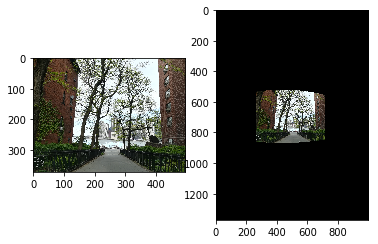

offset=  0
(372, 496, 3)


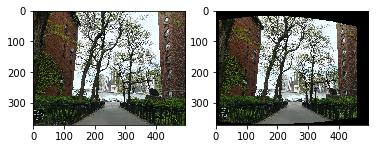

(372, 496, 3)


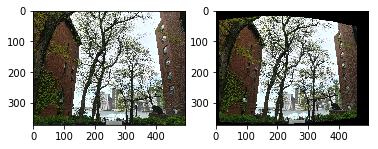

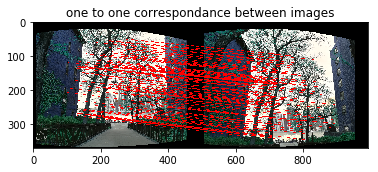

theta 0.5863136967976676 phi -6.888543015832463


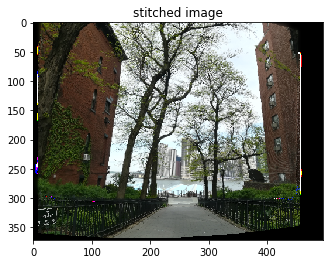

offset=  66
(438, 628, 3)


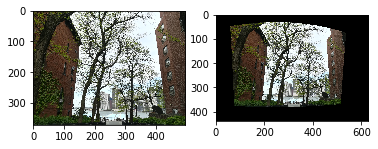

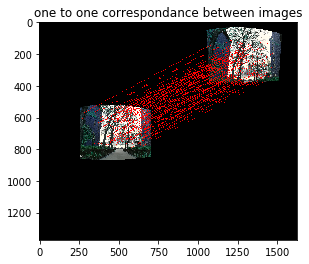

theta 23.807717637275793 phi 52.017761870077166


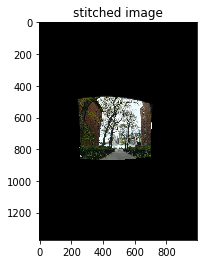

offset=  66
(438, 628, 3)


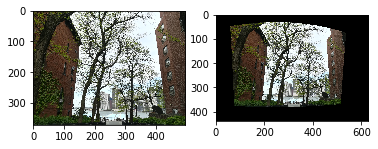

(438, 628, 3)


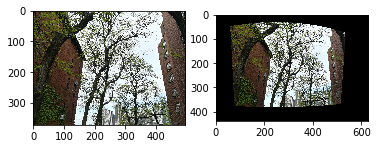

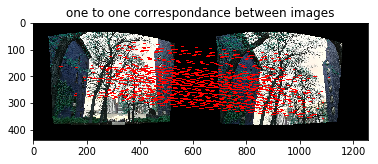

theta -1.1987041465799575 phi -5.821415122091067


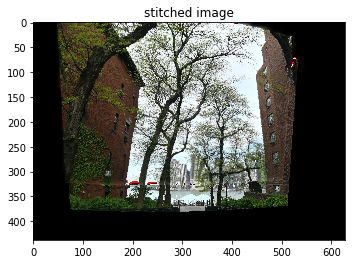

offset=  121
(493, 738, 3)


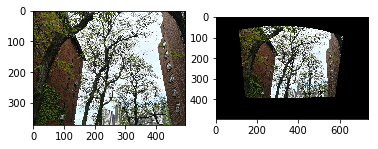

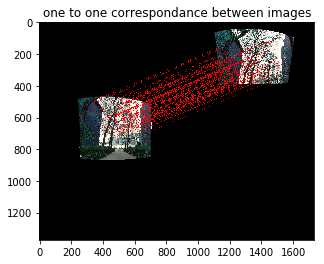

theta 13.886037399017816 phi 46.62162536432893


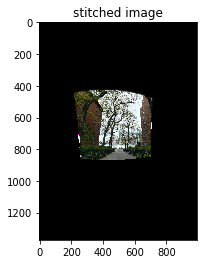

offset=  121
(493, 738, 3)


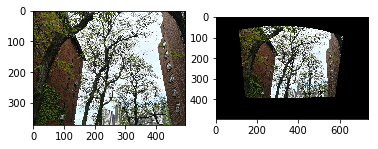

(493, 738, 3)


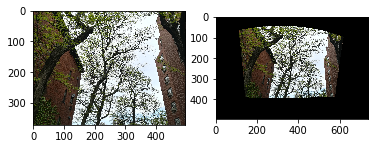

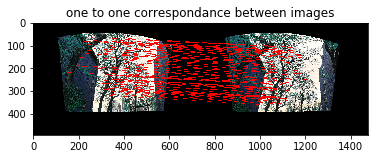

theta -1.0187077134273557 phi -4.186158449745097


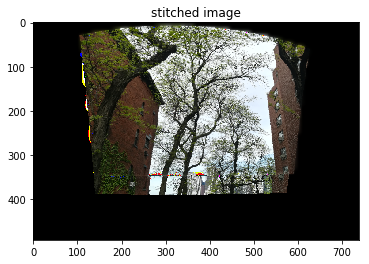

offset=  162
(534, 820, 3)


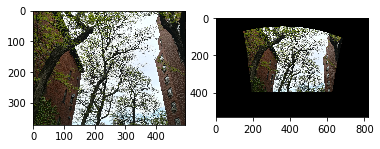

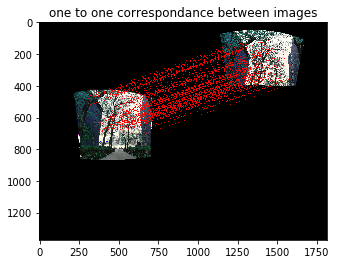

theta 8.01668954604439 phi 42.49149891146654


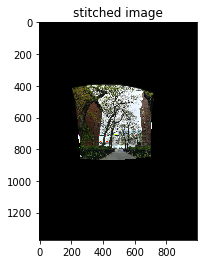

offset=  162
(534, 820, 3)


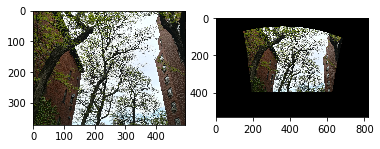

(534, 820, 3)


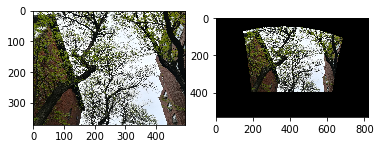

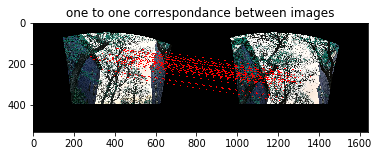

theta -6.071983859575361 phi -13.048811309554157


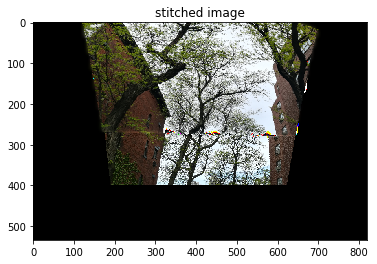

offset=  287
(659, 1070, 3)


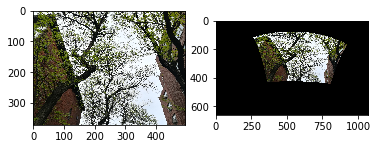

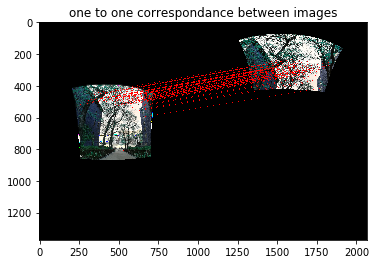

theta -16.230993818093065 phi 29.09890837610654


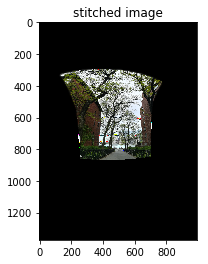

offset=  287
(659, 1070, 3)


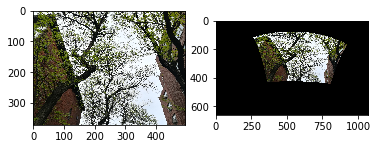

(659, 1070, 3)


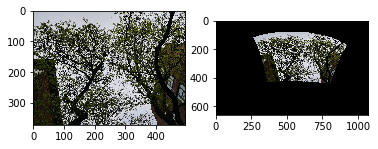

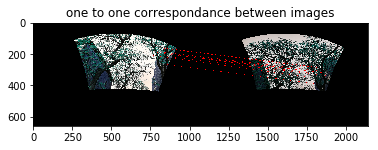

theta 3.188306246844121 phi -28.47064624728464


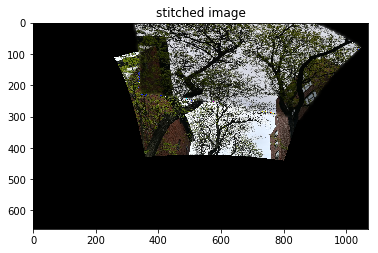

offset=  560
(932, 1616, 3)


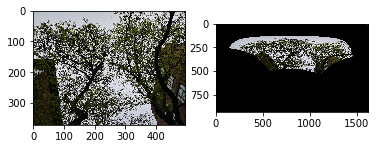

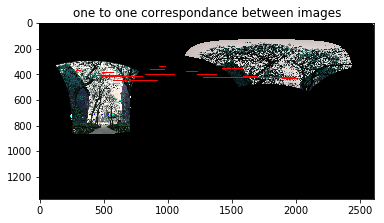

theta -27.76922940164707 phi 13.13299707294978


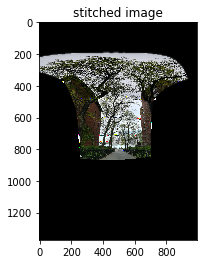

offset=  0
(372, 496, 3)


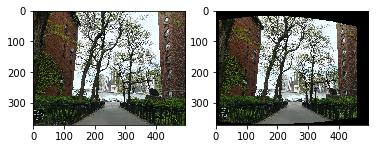

(372, 496, 3)


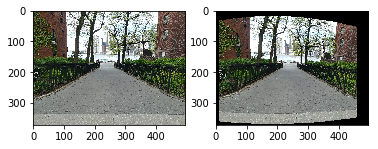

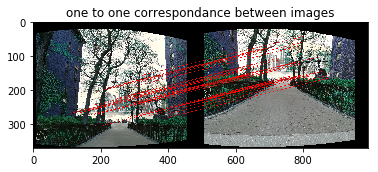

theta 1.90866421618022 phi 15.65411971186141


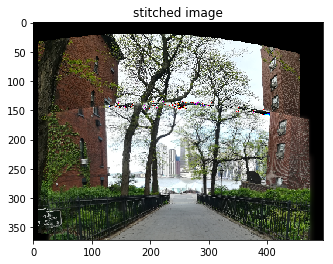

offset=  150
(522, 796, 3)


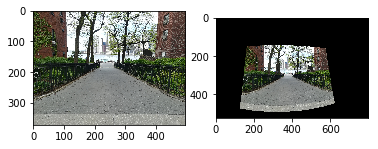

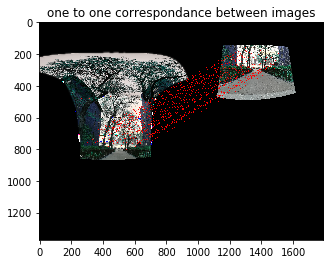

theta 16.876997853157256 phi 56.99983936547222


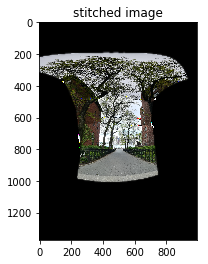

offset=  150
(522, 796, 3)


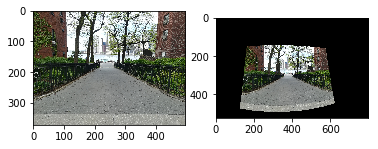

(522, 796, 3)


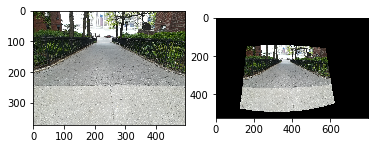

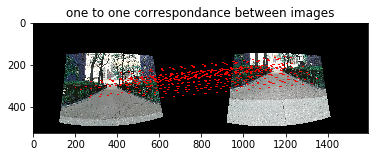

theta -0.23624935344490286 phi 11.033042189879039


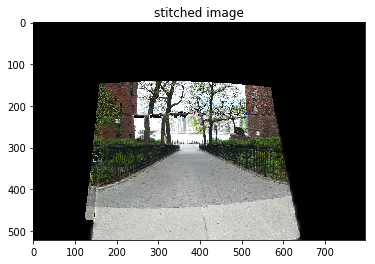

offset=  255
(627, 1006, 3)


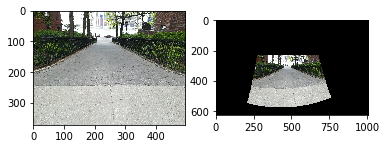

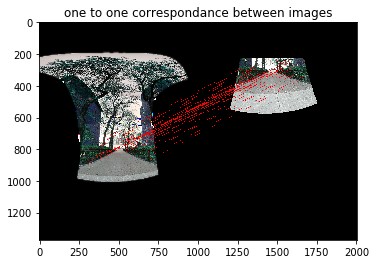

theta 5.305383987642301 phi 55.23130895483376


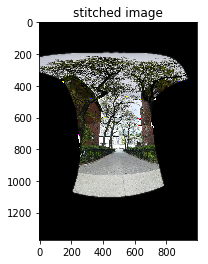

offset=  255
(627, 1006, 3)


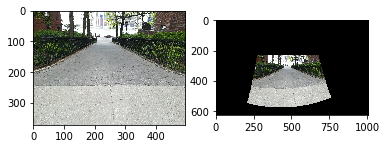

(627, 1006, 3)


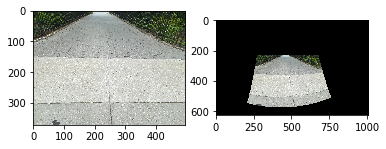

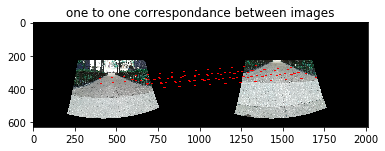

theta 0.7386084842215849 phi 14.590072833487824


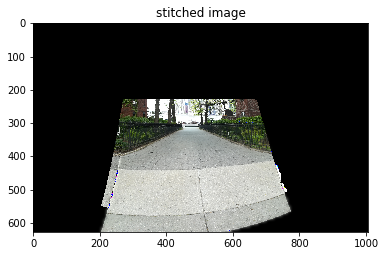

offset=  395
(767, 1286, 3)


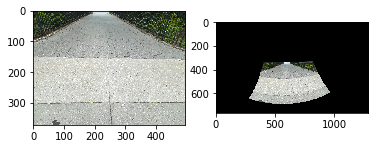

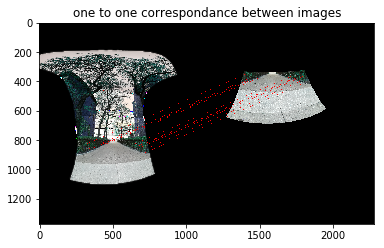

theta -8.613924230636387 phi 50.735356938698146


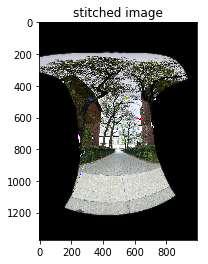

offset=  395
(767, 1286, 3)


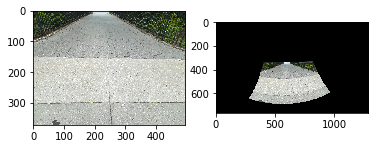

(767, 1286, 3)


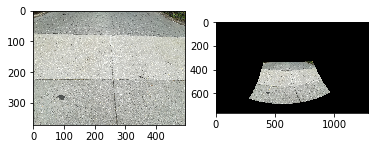

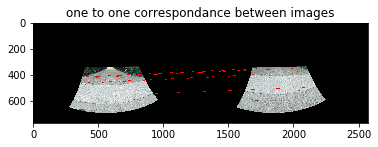

theta -7.837641253610032 phi 10.194997224851589


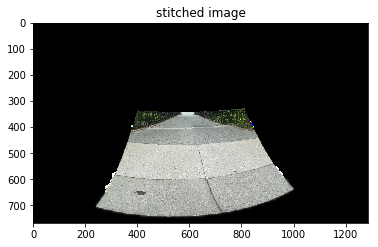

offset=  493
(865, 1482, 3)


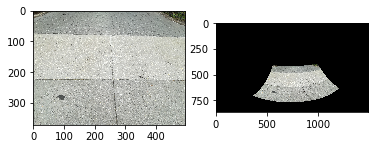

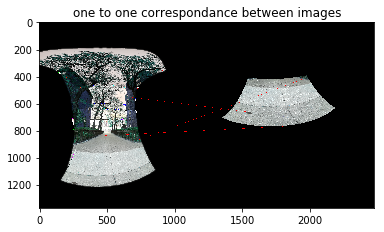

theta 120.91130988562116 phi -34.261824007077145


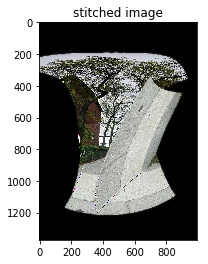

offset=  493
(865, 1482, 3)


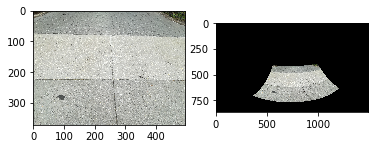

(865, 1482, 3)


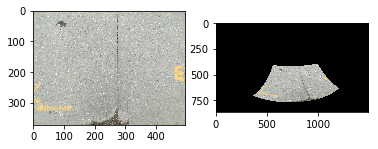

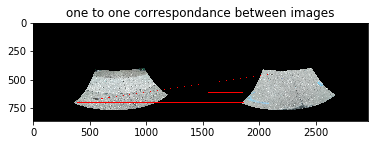

theta 91.63357861570763 phi 78.35324065621536


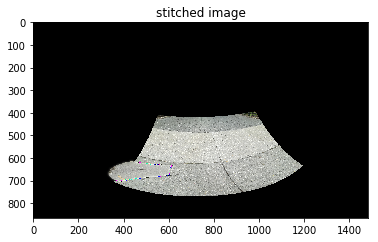

offset=  1244
(1616, 2984, 3)


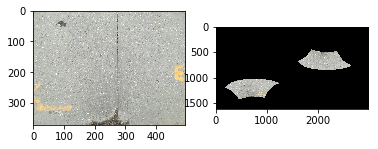

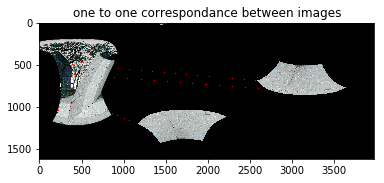

theta 30.708124673715712 phi -16.606564983693964


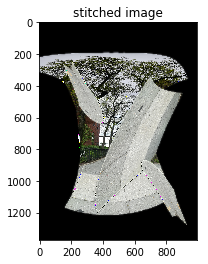

In [118]:
K_down=K/8
K_down[2][2]=1
img0 = cv2.imread("c0/imgr0.jpg",1)
temp = img0
theta_i=0
phi_i=0
output_i,mask_out = resize_SphericalWarping(img0,K_down,theta_i,phi_i,500,250)

images_up = glob.glob("c0/imgr+*.jpg")
images_down=glob.glob("c0/imgr-*.jpg")

output = []
for fname in images_up:
    img = cv2.imread(fname,1)
    output_i,theta_i,phi_i = verticalStitching(img,temp,output_i,theta_i,phi_i,K_down,1)
    output.append(output_i)
    temp = img

temp = img0
theta_i=0
phi_i=0
for fname in images_down:
    img = cv2.imread(fname,1)
    output_i,theta_i,phi_i = verticalStitching(img,temp,output_i,theta_i,phi_i,K_down,-1)
    output.append(output_i)
    temp = img
   

In [80]:
cv2.imwrite('output.png',output1)

# plt.imshow(cv2.cvtColor(output_i, cv2.COLOR_BGR2RGB))
# plt.savefig("output.png",bbox_inches='tight')

True